In [8]:
import os
from functools import partial
import json
import csv

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import random
import seaborn as sns

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

In [262]:
data = pd.read_csv("./Outputs/SEN12_texas_data4000.csv")

In [265]:
data.describe()

,seats,mm,pg
count,4000.000000,4000.000000,4000.000000
mean,24.368000,0.028638,0.043666
std,1.323826,0.016049,0.009704
min,21.000000,-0.014810,0.022405
25%,24.000000,0.018872,0.036652
50%,24.000000,0.030775,0.042952
75%,25.000000,0.039835,0.049298
max,28.000000,0.065831,0.076109


In [216]:
inliers.describe()

,seats,mm,pg
count,592.000000,592.000000,592.000000
mean,24.547297,0.032063,0.044331
std,0.498179,0.014340,0.006049
min,24.000000,-0.008860,0.030621
25%,24.000000,0.023135,0.039251
50%,25.000000,0.033297,0.044575
75%,25.000000,0.040020,0.048440
max,25.000000,0.065570,0.059770


In [217]:
dem.describe()

,seats,mm,pg
count,184.000000,184.000000,184.000000
mean,22.407609,0.036892,0.041662
std,0.662951,0.012639,0.007010
min,21.000000,0.013260,0.030318
25%,22.000000,0.027848,0.036394
50%,23.000000,0.033453,0.039318
75%,23.000000,0.041790,0.046041
max,23.000000,0.062936,0.061413


In [218]:
rep.describe()

,seats,mm,pg
count,224.0,224.000000,224.000000
mean,26.0,0.021292,0.041531
std,0.0,0.012156,0.005651
min,26.0,0.001446,0.031277
25%,26.0,0.013074,0.036953
50%,26.0,0.014641,0.040420
75%,26.0,0.032365,0.045352
max,26.0,0.047189,0.059745


In [260]:
inliers, rep, dem = winnow_data(data, [22, 26])

% of plans that were Dem outliers:  0.9625
% of plans that were Rep outliers:  0.723
% of plans that were inliers:  0.9285


In [261]:
inliers.describe()

,seats,mm,pg
count,1857.000000,1857.000000,1857.000000
mean,24.800754,0.033319,0.045993
std,1.105014,0.013444,0.008614
min,21.000000,-0.008860,0.030318
25%,24.000000,0.024870,0.039347
50%,25.000000,0.033410,0.045212
75%,26.000000,0.041914,0.050689
max,26.000000,0.065570,0.076109


In [259]:
def winnow_data(data, inliers_list):
    dem = data.set_index("seats")
    rep = data.set_index("seats")
    inliers = data.set_index("seats")

    for i in [inliers_list[0], max(data["seats"])]:
        dem = dem.drop(i, axis = 0)

    for i in [min(data["seats"]), inliers_list[1]]:
        rep = rep.drop(i, axis = 0)

    for i in [min(data["seats"]), inliers_list[0]-1] and [inliers_list[1]+1, max(data["seats"])]:
        inliers = inliers.drop(i, axis = 0)

    dem = dem.reset_index()
    rep = rep.reset_index()
    inliers = inliers.reset_index()
    
    print("% of plans that were Dem outliers: ", len(dem)/len(data))
    print("% of plans that were Rep outliers: ", len(rep)/len(data))
    print("% of plans that were inliers: ", len(inliers)/len(data))
    return inliers, rep, dem

In [266]:
dem = data.set_index("seats")
rep = data.set_index("seats")
inliers = data.set_index("seats")

for i in (22, 23, 24, 25, 26, 27, 28):
    dem = dem.drop(i, axis = 0)
    
for i in (21, 22, 23, 24, 25, 26):
    rep = rep.drop(i, axis = 0)
    
for i in (21, 27, 28):
    inliers = inliers.drop(i, axis = 0)
    
dem = dem.reset_index()
rep = rep.reset_index()
inliers = inliers.reset_index()

In [ ]:
for plan in tqdm_notebook(data):
    mm.append(plan[1])
    pg.append(plan[2])
    vs.append(plan[3])
    if plan[0] < inliers[0]:
        seats_doutliers.append(plan[0])
        mm_doutliers.append(plan[1])
        pg_doutliers.append(plan[2])
        vs_doutliers.append(plan[3])
    if plan[0] > inliers[1]:
        seats_routliers.append(plan[0])
        mm_routliers.append(plan[1])
        pg_routliers.append(plan[2])
        vs_routliers.append(plan[3])
    if plan[0] >= inliers[0] and plan[0] <= inliers[1]:
        seats_inliers.append(plan[0])

In [340]:
texas_data = pd.read_csv("./Outputs/SEN12_texas_data6000.csv")

In [342]:
utah_data = pd.read_csv("./Outputs/utah_data5000.csv")

In [348]:
def binning_seats(data):
    seats_data = []
    for i in range(len(data)):
        seats_data.append(data["seats"][i])
    return max(seats_data) - min(seats_data) + 1

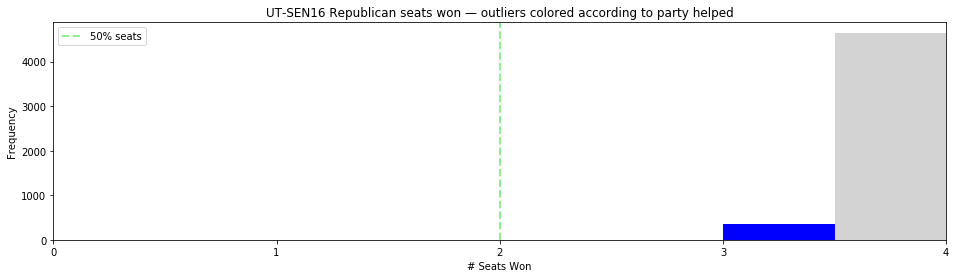

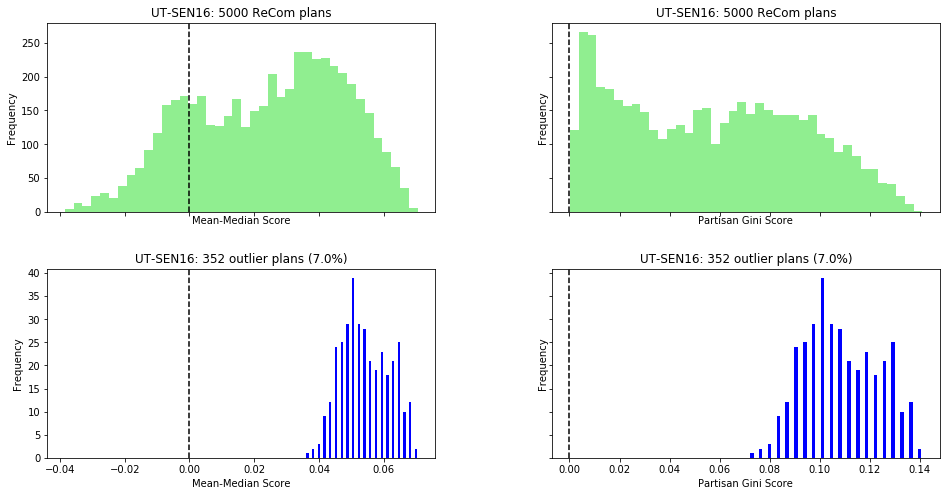

In [346]:
visualize("UT-SEN16", utah_data, [4,4], 4)

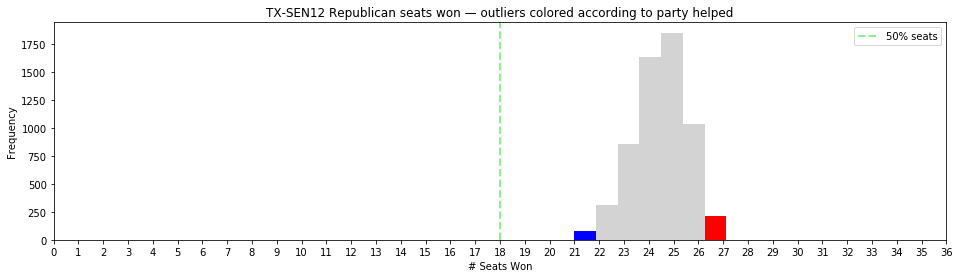

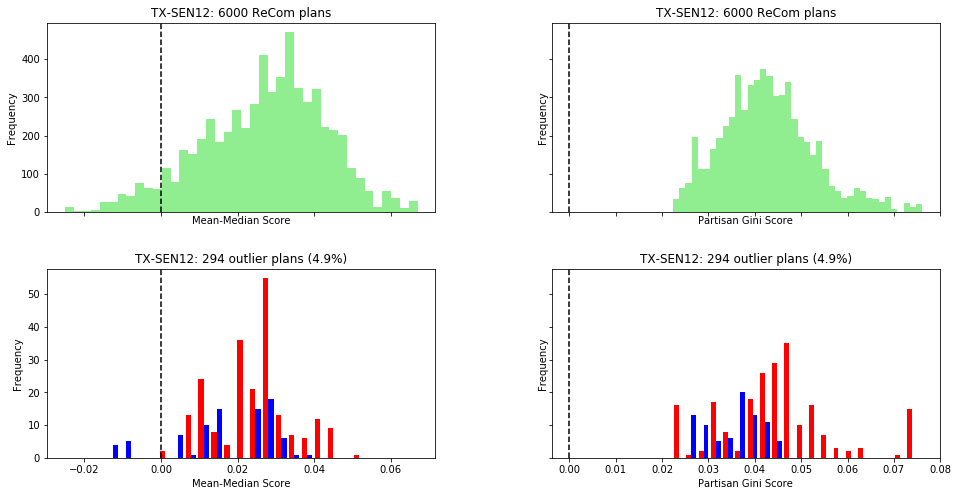

In [347]:
visualize("TX-SEN12", texas_data, [22, 26], 36)

In [349]:
def visualize(state, data, inliers, num_dist):
    fig, seats = plt.subplots(figsize=(16,4))
    fig, ax = plt.subplots(2,2, figsize=(16,8), sharex="col", sharey="row")

    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Variables
    bins_num = 20
    out_bins_num = binning_seats(data)
    num_steps = len(data)
    title = state + ": " + str(num_steps) + " ReCom plans"

    # Colors
    seats_colors = ["red", "blue", "lightgray"]
    party_colors = ["red", "blue"]
    neutral = "lightgreen"

    mm = []
    pg = []
    vs = []
    mm_routliers = []
    mm_doutliers = []
    pg_routliers = []
    pg_doutliers = []
    seats_routliers = []
    seats_doutliers = []
    seats_inliers = []
    vs_routliers = []
    vs_doutliers = []

    for i in range(len(data)):
        mm.append(data["mm"][i])
        pg.append(data["pg"][i])
        vs.append(data["vs"][i])
        if data["seats"][i] < inliers[0]:
            seats_doutliers.append(data["seats"][i])
            mm_doutliers.append(data["mm"][i])
            pg_doutliers.append(data["pg"][i])
            vs_doutliers.append(data["vs"][i])
        if data["seats"][i] > inliers[1]:
            seats_routliers.append(data["seats"][i])
            mm_routliers.append(data["mm"][i])
            pg_routliers.append(data["pg"][i])
            vs_routliers.append(data["vs"][i])
        if data["seats"][i] >= inliers[0] and data["seats"][i] <= inliers[1]:
            seats_inliers.append(data["seats"][i])

    mms = [mm_routliers, mm_doutliers]
    pgs = [pg_routliers, pg_doutliers]
    seats_colored = [seats_routliers, seats_doutliers, seats_inliers]

    # More variables
    num_outliers = str(len(mm_doutliers) + len(mm_routliers))
    pct_outliers = str(round((len(mm_doutliers) + len(mm_routliers)) / num_steps * 100, 1))
    title_w = state + ": " + num_outliers + " outlier plans " + "(" + pct_outliers + "%)"


    # Plotting the seats histogram
    seats.hist(seats_colored, bins=out_bins_num, stacked=True, color=seats_colors)

    seats.set_title(state + " Republican seats won — outliers colored according to party helped")
    seats.set_ylabel("Frequency")
    seats.set_xlabel("# Seats Won")
    seats.set_xlim(0, num_dist)
    seats.axvline(x = num_dist/2, color=neutral, linestyle="dashed", linewidth=2, label="50% seats")
    # seats.axvline(x = num_dist * initial_partition[election].percent("republican"), color="red", linestyle="dashed", linewidth=2, label="proportionality")
    seats.legend()
    seats.set_xticks(range(num_dist + 1))

    # Plotting the whole dataset
    ax[0,0].hist(mm, bins=2*bins_num, color=neutral)
    ax[0,1].hist(pg, bins=2*bins_num, color=neutral)

    # Plotting the ideal values of metrics on each plot
    ax[0,0].axvline(x=0, color="black", linestyle="dashed", label = "ideal value")
    ax[1,0].axvline(x=0, color="black", linestyle="dashed", label = "ideal value")
    ax[0,1].axvline(x=0, color="black", linestyle="dashed", label = "ideal value")
    ax[1,1].axvline(x=0, color="black", linestyle="dashed", label = "ideal value")

    ax[0,0].set_title(title)
    ax[0,0].set_ylabel("Frequency")
    ax[0,0].set_xlabel("Mean-Median Score")

    ax[0,1].set_title(title)
    ax[0,1].set_ylabel("Frequency")
    ax[0,1].set_xlabel("Partisan Gini Score")

    # Plotting the winnowed data
    ax[1,0].hist(mms, bins=bins_num, color=party_colors)
    ax[1,1].hist(pgs, bins=bins_num, color=party_colors)
    # ax[1,1].set_ylim((0,40))

    ax[1,0].set_title(title_w)
    ax[1,0].set_ylabel("Frequency")
    ax[1,0].set_xlabel("Mean-Median Score")

    ax[1,1].set_title(title_w)
    ax[1,1].set_ylabel("Frequency")
    ax[1,1].set_xlabel("Partisan Gini Score")
    plt.show()

Text(0.5, 0, 'Partisan Gini Score')

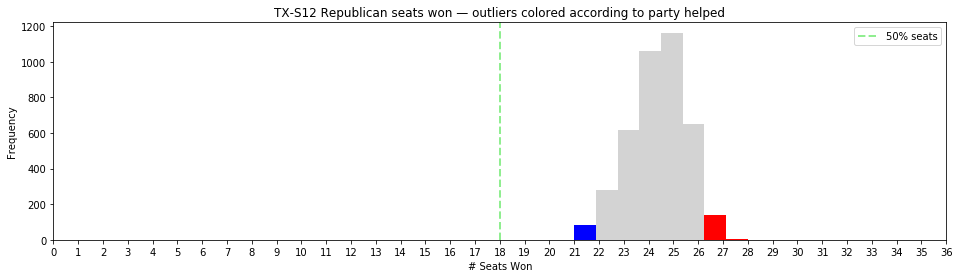

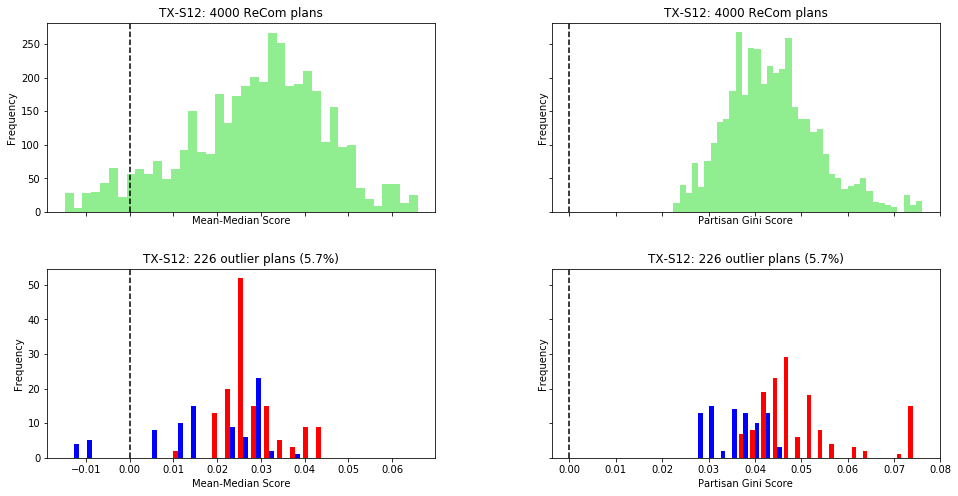

In [320]:
# fig, votes = plt.subplots(figsize=(16,4))
fig, seats = plt.subplots(figsize=(16,4))
fig, ax = plt.subplots(2,2, figsize=(16,8), sharex="col", sharey="row")

plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Variables
inliers = [22,26]
bins_num = 20
out_bins_num = 8
title = "TX-S12: 4000 ReCom plans"
num_dist = 36

# Colors
seats_colors = ["red", "blue", "lightgray"]
party_colors = ["red", "blue"]
neutral = "lightgreen"

mm = []
pg = []
vs = []
mm_routliers = []
mm_doutliers = []
pg_routliers = []
pg_doutliers = []
seats_routliers = []
seats_doutliers = []
seats_inliers = []
vs_routliers = []
vs_doutliers = []

for i in range(len(data)):
    mm.append(data["mm"][i])
    pg.append(data["pg"][i])
    vs.append(data["vs"][i])
    if data["seats"][i] < inliers[0]:
        seats_doutliers.append(data["seats"][i])
        mm_doutliers.append(data["mm"][i])
        pg_doutliers.append(data["pg"][i])
        vs_doutliers.append(data["vs"][i])
    if data["seats"][i] > inliers[1]:
        seats_routliers.append(data["seats"][i])
        mm_routliers.append(data["mm"][i])
        pg_routliers.append(data["pg"][i])
        vs_routliers.append(data["vs"][i])
    if data["seats"][i] >= inliers[0] and data["seats"][i] <= inliers[1]:
        seats_inliers.append(data["seats"][i])

mms = [mm_routliers, mm_doutliers]
pgs = [pg_routliers, pg_doutliers]
seats_colored = [seats_routliers, seats_doutliers, seats_inliers]

# More variables
num_outliers = str(len(mm_doutliers) + len(mm_routliers))
pct_outliers = str(round((len(mm_doutliers) + len(mm_routliers)) / 4000 * 100, 1))
title_w = "TX-S12: " + num_outliers + " outlier plans " + "(" + pct_outliers + "%)"


# Plotting the seats histogram
seats.hist(seats_colored, bins=out_bins_num, stacked=True, color=seats_colors)

seats.set_title("TX-S12 Republican seats won — outliers colored according to party helped")
seats.set_ylabel("Frequency")
seats.set_xlabel("# Seats Won")
seats.set_xlim(0, num_dist)
seats.axvline(x = num_dist/2, color=neutral, linestyle="dashed", linewidth=2, label="50% seats")
# seats.axvline(x = num_dist * initial_partition[election].percent("republican"), color="red", linestyle="dashed", linewidth=2, label="proportionality")
seats.legend()
seats.set_xticks(range(37))

# Plotting the whole dataset
ax[0,0].hist(mm, bins=2*bins_num, color=neutral)
ax[0,1].hist(pg, bins=2*bins_num, color=neutral)

# Plotting the ideal values of metrics on each plot
ax[0,0].axvline(x=0, color="black", linestyle="dashed", label = "ideal value")
ax[1,0].axvline(x=0, color="black", linestyle="dashed", label = "ideal value")
ax[0,1].axvline(x=0, color="black", linestyle="dashed", label = "ideal value")
ax[1,1].axvline(x=0, color="black", linestyle="dashed", label = "ideal value")

ax[0,0].set_title(title)
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_xlabel("Mean-Median Score")

ax[0,1].set_title(title)
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_xlabel("Partisan Gini Score")

# Plotting the winnowed data
ax[1,0].hist(mms, bins=bins_num, color=party_colors)
ax[1,1].hist(pgs, bins=bins_num, color=party_colors)
# ax[1,1].set_ylim((0,40))

ax[1,0].set_title(title_w)
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_xlabel("Mean-Median Score")

ax[1,1].set_title(title_w)
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_xlabel("Partisan Gini Score")

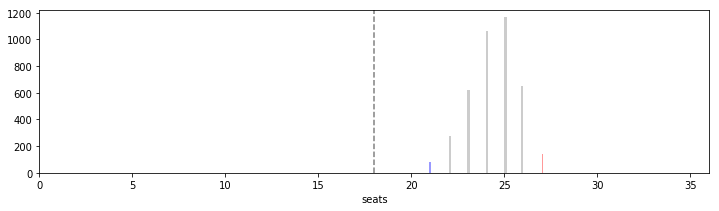

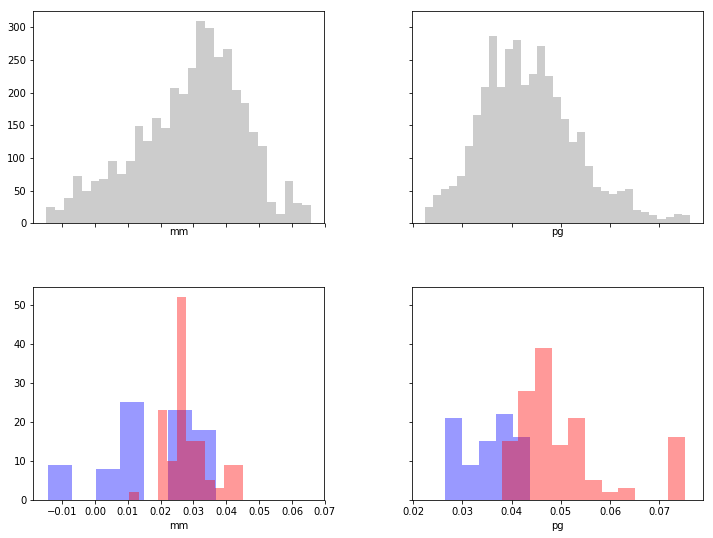

In [267]:
fig, seats = plt.subplots(figsize=(12,3))
fig, axes = plt.subplots(2,2, figsize = (12,9), sharex="col", sharey="row")

plt.subplots_adjust(wspace=0.3, hspace=0.3)

data_list = [inliers, rep, dem]
color_list = ["gray", "red", "blue"]
num_bins = 20

# sns.distplot(data["seats"], color="orange", ax=seats, kde=False)

seats.set_xlim(0, 36)
seats.axvline(x=18, label="50%", color="gray", linestyle="dashed")

sns.distplot(inliers["seats"], color="gray", ax=seats, kde=False)
sns.distplot(dem["seats"], color="blue", ax=seats, kde=False)
sns.distplot(rep["seats"], color="red", ax=seats, kde=False)

sns.distplot(inliers["mm"], color="gray", ax=axes[0,0], kde=False)
sns.distplot(inliers["pg"], color="gray", ax=axes[0,1], kde=False)

sns.distplot(dem["mm"], color="blue", ax=axes[1,0], kde=False)
sns.distplot(rep["mm"], color="red", ax=axes[1,0], kde=False)

sns.distplot(dem["pg"], color="blue", ax=axes[1,1], kde=False)
sns.distplot(rep["pg"], color="red", ax=axes[1,1], kde=False)

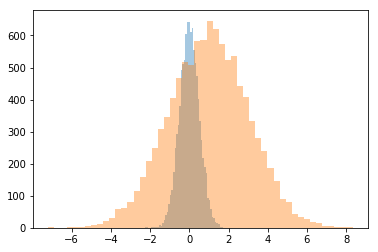

In [203]:
d = np.random.normal(0, .5, 10000)
f = np.random.normal(1, 2, 10000)

sns.distplot(d, kde=False)
sns.distplot(f, kde=False)